# DSSL25 - UC1

In [1]:
# On MacOS, accessing UCI ML Repository datasets often fails due to SSL certificate verification issues.
# This script provides a way to bypass SSL verification for trusted sources like UCI ML Repository.
import ssl
import urllib.request
import urllib.parse
from typing import Optional


def disable_ssl_verification():
    """
    Globally disable SSL certificate verification for urllib requests.

    This function modifies the default SSL context to bypass certificate
    verification issues commonly encountered on macOS when accessing
    UCI ML Repository datasets.

    Note: This reduces security by disabling certificate verification.
    Use only for trusted sources like UCI ML Repository.

    Returns:
        None
    """
    try:
        # Create an unverified SSL context
        ssl_context = ssl.create_default_context()
        ssl_context.check_hostname = False
        ssl_context.verify_mode = ssl.CERT_NONE

        # Create a custom HTTPS handler with unverified SSL context
        https_handler = urllib.request.HTTPSHandler(context=ssl_context)

        # Install the custom handler globally
        opener = urllib.request.build_opener(https_handler)
        urllib.request.install_opener(opener)

        print("✅ SSL certificate verification disabled globally")
        print("🔒 Warning: This reduces security - use only for trusted sources")

    except Exception as e:
        print(f"❌ Failed to disable SSL verification: {e}")
        raise


def enable_ssl_verification():
    """
    Re-enable SSL certificate verification by restoring default settings.

    This function restores the default SSL context and HTTPS handler,
    re-enabling certificate verification for security.

    Returns:
        None
    """
    try:
        # Create default SSL context (with verification)
        ssl_context = ssl.create_default_context()

        # Create default HTTPS handler
        https_handler = urllib.request.HTTPSHandler(context=ssl_context)

        # Install the default handler
        opener = urllib.request.build_opener(https_handler)
        urllib.request.install_opener(opener)

        print("✅ SSL certificate verification re-enabled")

    except Exception as e:
        print(f"❌ Failed to re-enable SSL verification: {e}")
        raise


def fetch_with_ssl_bypass(name: Optional[str] = None, id: Optional[int] = None):
    """
    Fetch UCI ML Repository dataset with automatic SSL bypass.

    This function temporarily disables SSL verification, fetches the dataset,
    then re-enables SSL verification for security.

    Parameters:
        name (str, optional): Dataset name or substring
        id (int, optional): Dataset ID

    Returns:
        Dataset object from ucimlrepo

    Example:
        from ssl_validation import fetch_with_ssl_bypass
        data = fetch_with_ssl_bypass(name='Iris')
    """
    from ucimlrepo import fetch_ucirepo

    # Store original state
    original_ssl_context = ssl.create_default_context()

    try:
        # Temporarily disable SSL verification
        disable_ssl_verification()

        # Fetch the dataset
        if name and id:
            raise ValueError('Only specify either dataset name or ID, not both')
        elif name:
            data = fetch_ucirepo(name=name)
        elif id:
            data = fetch_ucirepo(id=id)
        else:
            raise ValueError('Must provide either dataset name or ID')

        print(f"✅ Successfully fetched dataset")
        return data

    finally:
        # Always re-enable SSL verification for security
        enable_ssl_verification()


def configure_pandas_ssl():
    """
    Configure pandas to work with SSL certificate issues.

    This function sets up pandas to handle HTTPS URLs with SSL certificate
    verification disabled, which is specifically useful for reading CSV files
    from UCI ML Repository.

    Returns:
        None
    """
    try:
        # Import pandas to configure its URL handling
        import pandas as pd

        # Create unverified SSL context
        ssl_context = ssl.create_default_context()
        ssl_context.check_hostname = False
        ssl_context.verify_mode = ssl.CERT_NONE

        # Monkey patch pandas' URL opener to use unverified SSL
        original_urlopen = urllib.request.urlopen

        def patched_urlopen(url, *args, **kwargs):
            if isinstance(url, str) and url.startswith('https://'):
                kwargs['context'] = ssl_context
            return original_urlopen(url, *args, **kwargs)

        urllib.request.urlopen = patched_urlopen

        print("✅ Pandas SSL configuration applied")

    except Exception as e:
        print(f"❌ Failed to configure pandas SSL: {e}")
        raise


# Convenience function for common use case
def setup_uci_ssl_bypass():
    """
    One-time setup function to configure SSL bypass for UCI ML Repository.

    Call this once at the beginning of your script to enable seamless
    access to UCI ML Repository datasets without SSL certificate issues.

    Example:
        from ssl_validation import setup_uci_ssl_bypass
        setup_uci_ssl_bypass()

        # Now you can use fetch_ucirepo normally
        from ucimlrepo import fetch_ucirepo
        data = fetch_ucirepo(name='Iris')
    """
    print("🔧 Setting up UCI ML Repository SSL bypass...")
    disable_ssl_verification()
    configure_pandas_ssl()
    print("🎉 Setup complete! UCI ML Repository should now work without SSL issues")


if __name__ == "__main__":
    # Test the SSL bypass functionality
    print("Testing SSL validation bypass...")

    try:
        setup_uci_ssl_bypass()

        # Test fetch_ucirepo
        from ucimlrepo import fetch_ucirepo
        data = fetch_ucirepo(name='Iris')

        print(f"✅ Test successful! Dataset shape: {data.data.features.shape}")

    except Exception as e:
        print(f"❌ Test failed: {e}")

    finally:
        # Re-enable SSL for security
        enable_ssl_verification()
        print("🔒 SSL verification re-enabled for security")

Testing SSL validation bypass...
🔧 Setting up UCI ML Repository SSL bypass...
✅ SSL certificate verification disabled globally
🔒 Warning: This reduces security - use only for trusted sources
✅ Pandas SSL configuration applied
🎉 Setup complete! UCI ML Repository should now work without SSL issues
✅ Test successful! Dataset shape: (150, 4)
✅ SSL certificate verification re-enabled
🔒 SSL verification re-enabled for security


In [2]:
disable_ssl_verification()

# Now we'll fetch_ucirepo will work without SSL certificate issues
from ucimlrepo import fetch_ucirepo, list_available_datasets


✅ SSL certificate verification disabled globally
🔒 Warning: This reduces security - use only for trusted sources


In [3]:
# Some helper functions
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


def compute_pmf_table(df: pd.DataFrame, column_name: str) -> pd.DataFrame:
    '''
    Return the Probability Mass Function (PMF) of a categorical column
    '''
    probs = df[column_name].value_counts(normalize=True)
    end_intervall = probs.cumsum()
    start_intervall = end_intervall - probs

    return pd.DataFrame({
        'start_intervall': start_intervall,
        'end_intervall': end_intervall
    })

def assign_label(pmf: pd.DataFrame, p: float) -> str:
    '''
    Make inference about the class given the PMF

    Parameters:
    ----------
    df : pd.DataFrame
        The DataFrame containing the column to process.
    p : float
        A random number between 0 and 1 used to calcule the label.

    '''
    for row in range(pmf.shape[0]):
        if p > pmf['start_intervall'].iloc[row] and p <= pmf['end_intervall'].iloc[row]:
            return pmf.index[row]
    return None

def fill_na_PMF(df: pd.DataFrame, column_name: str) -> pd.DataFrame:
    """
    Fills missing (NaN) values in a categorical column of a DataFrame
    by sampling from its empirical Probability Mass Function (PMF).

    Parameters:
    ----------
    df : pd.DataFrame
        The DataFrame containing the column to process.
    column_name : str
        The name of the categorical column to fill.

    Returns:
    -------
    pd.DataFrame
        The input DataFrame with missing values in the specified column replaced
        by values sampled according to the column's PMF.
    """

    pmf = compute_pmf_table (df, column_name)
    for i in range(df.shape[0]):
        if pd.isna(df.loc[i, column_name]):
            p = np.random.rand()
            df.loc[i, column_name] = assign_label(pmf, p)
    return df

In [4]:
# special import for the adult dataset
from ucimlrepo import fetch_ucirepo, list_available_datasets

# fetch dataset
adult = fetch_ucirepo(id=2)

# data (as pandas dataframes)
X = adult.data.features
y = adult.data.targets

df = X
df['y'] = y


In [44]:
print(adult.metadata)
print(adult.variables)

{'uci_id': 2, 'name': 'Adult', 'repository_url': 'https://archive.ics.uci.edu/dataset/2/adult', 'data_url': 'https://archive.ics.uci.edu/static/public/2/data.csv', 'abstract': 'Predict whether annual income of an individual exceeds $50K/yr based on census data. Also known as "Census Income" dataset. ', 'area': 'Social Science', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 48842, 'num_features': 14, 'feature_types': ['Categorical', 'Integer'], 'demographics': ['Age', 'Income', 'Education Level', 'Other', 'Race', 'Sex'], 'target_col': ['income'], 'index_col': None, 'has_missing_values': 'yes', 'missing_values_symbol': 'NaN', 'year_of_dataset_creation': 1996, 'last_updated': 'Tue Sep 24 2024', 'dataset_doi': '10.24432/C5XW20', 'creators': ['Barry Becker', 'Ronny Kohavi'], 'intro_paper': None, 'additional_info': {'summary': "Extraction was done by Barry Becker from the 1994 Census database.  A set of reasonably clean records was extracted using the fol

#### Variables and Their Descriptions
* age
* workclass: Sector in which the person works
* fnlwgt: Weight indicating how well the sample represents the population
* education: Level of education of the person
* education.num: Level of education of the person (numbered)
* marital.status: Marital status of the person
* occupation: Occupation group of the person
* relationship: Relationship status of the person within the family
* race: Race of the person
* sex: Gender of the person
* capital.gain: Gain of the person's capital/investment
* capital.loss: Loss of the person's capital/investment
* hours.per.week: Total weekly working hours
* native.country: Home country of the person
* income: Income level of the person (Target variable)

In [5]:
display(df)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,y
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48837,39,Private,215419,Bachelors,13,Divorced,Prof-specialty,Not-in-family,White,Female,0,0,36,United-States,<=50K.
48838,64,NaN,321403,HS-grad,9,Widowed,NaN,Other-relative,Black,Male,0,0,40,United-States,<=50K.
48839,38,Private,374983,Bachelors,13,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,50,United-States,<=50K.
48840,44,Private,83891,Bachelors,13,Divorced,Adm-clerical,Own-child,Asian-Pac-Islander,Male,5455,0,40,United-States,<=50K.


Let's print some column histograms...

y                    <=50K    <=50K.      >50K     >50K.
workclass                                               
?                 0.066545  0.000000  0.024359  0.000000
Federal-gov       0.023827  0.024424  0.047315  0.050371
Local-gov         0.059709  0.063485  0.078689  0.082185
Never-worked      0.000283  0.000260  0.000000  0.000000
Private           0.717354  0.760956  0.632955  0.642630
Self-emp-inc      0.019984  0.022778  0.079327  0.083775
Self-emp-not-inc  0.073503  0.083839  0.092335  0.093584
State-gov         0.038228  0.043825  0.045020  0.046925
Without-pay       0.000566  0.000433  0.000000  0.000530
y                <=50K    <=50K.      >50K     >50K.
education                                           
10th          0.035235  0.034660  0.007907  0.006500
11th          0.045105  0.048653  0.007652  0.008320
12th          0.016181  0.016807  0.004209  0.003900
1st-4th       0.006553  0.006192  0.000765  0.000520
5th-6th       0.012824  0.013269  0.002041  0.002860
7t

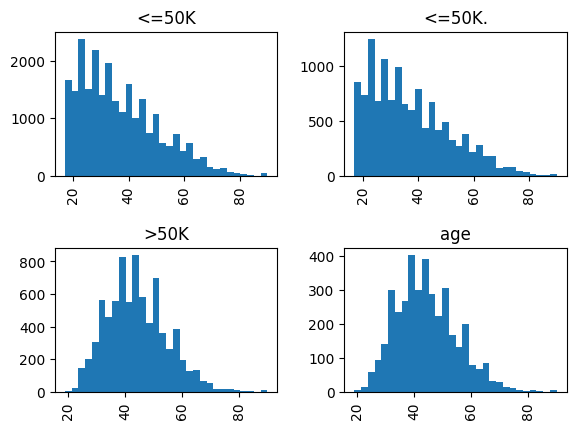

fnlwgt


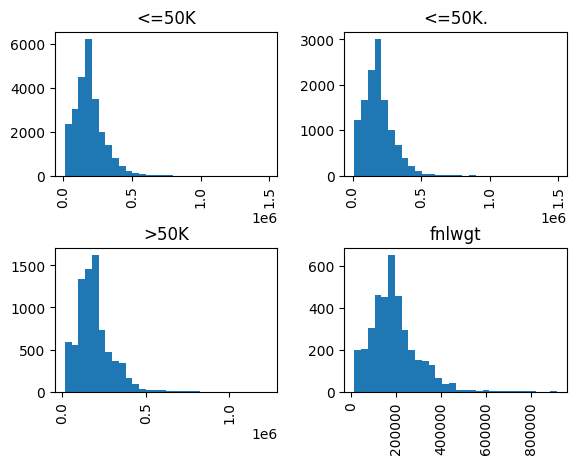

education-num


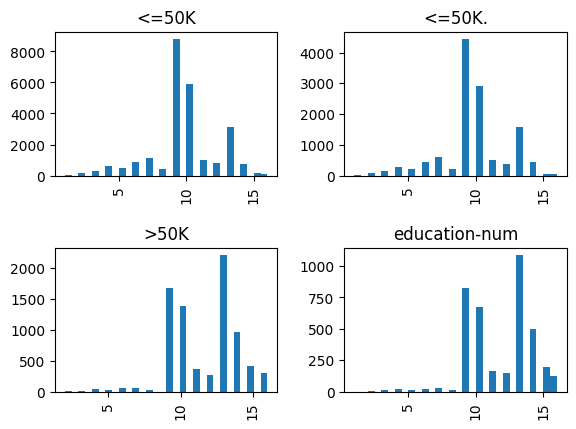

capital-gain


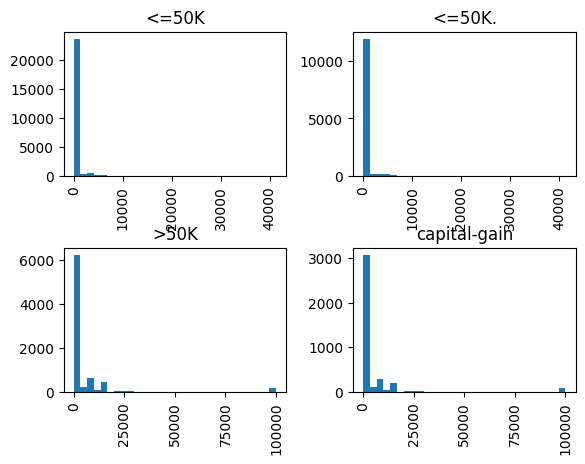

capital-loss


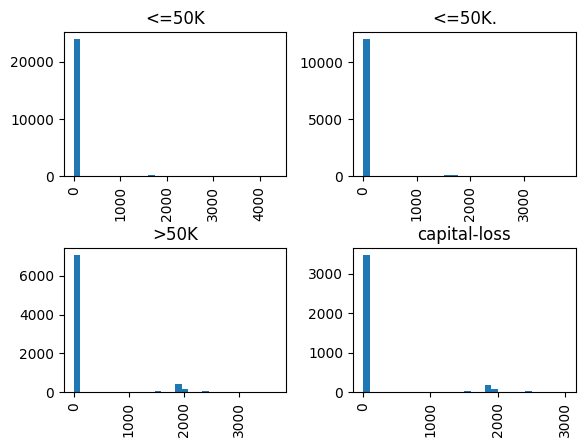

hours-per-week


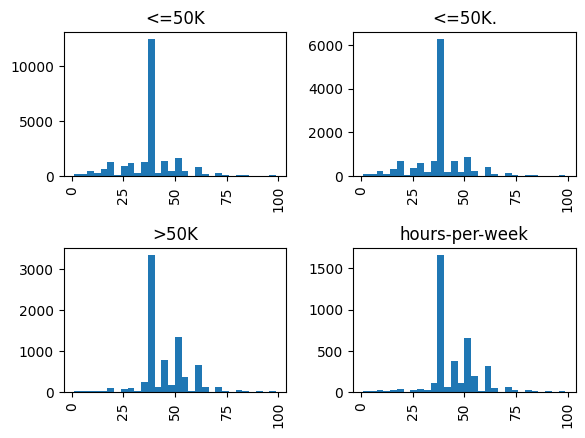

In [ ]:

for column in df.select_dtypes(include=['object']).columns:
    if column != 'y':
        print(pd.crosstab(index=df[column], columns=df['y'], normalize='columns'))

for column in df.select_dtypes(exclude=['object']).columns:
    print(column)
    hist = df[[column, 'y']].hist(by='y', bins=30)
    plt.title(column)
    plt.show()

### Correlation of features

                     age    fnlwgt  education-num  capital-gain  capital-loss  \
age             1.000000 -0.076628       0.030940      0.077229      0.056944   
fnlwgt         -0.076628  1.000000      -0.038761     -0.003706     -0.004366   
education-num   0.030940 -0.038761       1.000000      0.125146      0.080972   
capital-gain    0.077229 -0.003706       0.125146      1.000000     -0.031441   
capital-loss    0.056944 -0.004366       0.080972     -0.031441      1.000000   
hours-per-week  0.071558 -0.013519       0.143689      0.082157      0.054467   

                hours-per-week  
age                   0.071558  
fnlwgt               -0.013519  
education-num         0.143689  
capital-gain          0.082157  
capital-loss          0.054467  
hours-per-week        1.000000  


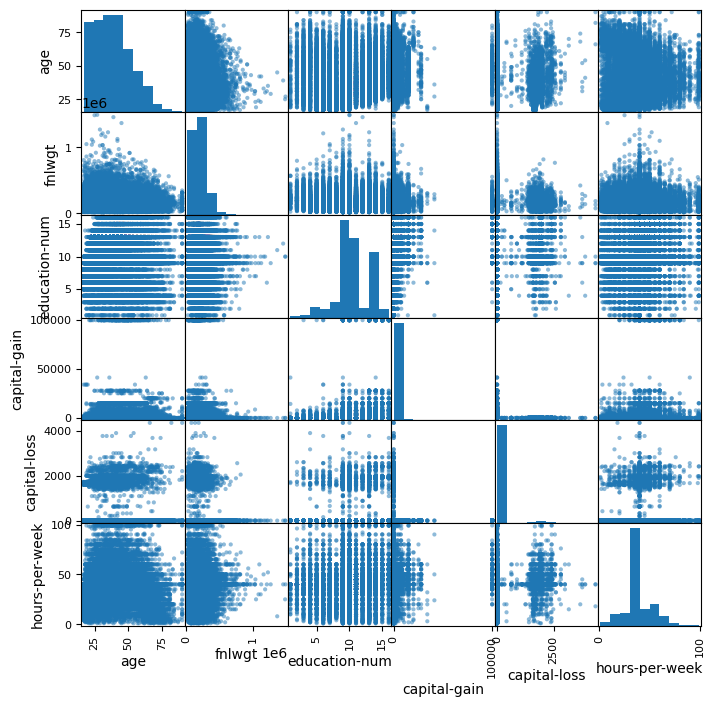

In [8]:
print(data.corr(numeric_only=True))
pd.plotting.scatter_matrix(data, figsize=(8, 8))
plt.show()

### Missing data ?

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             48842 non-null  int64 
 1   workclass       47879 non-null  object
 2   fnlwgt          48842 non-null  int64 
 3   education       48842 non-null  object
 4   education-num   48842 non-null  int64 
 5   marital-status  48842 non-null  object
 6   occupation      47876 non-null  object
 7   relationship    48842 non-null  object
 8   race            48842 non-null  object
 9   sex             48842 non-null  object
 10  capital-gain    48842 non-null  int64 
 11  capital-loss    48842 non-null  int64 
 12  hours-per-week  48842 non-null  int64 
 13  native-country  48568 non-null  object
 14  y               48842 non-null  object
dtypes: int64(6), object(9)
memory usage: 5.6+ MB


In [6]:
null_cols = []
for c in df.columns:
    if df[c].isna().any():
        print(f"[WARN] Column '{c}' has missing values")
        null_cols.append(c)



[WARN] Column 'workclass' has missing values
[WARN] Column 'occupation' has missing values
[WARN] Column 'native-country' has missing values


In [7]:
# Impute column values and check again
for column in null_cols:
    df = fill_na_PMF(df, column)

for c in df.columns:
    if df[c].isna().any():
        print(f"[WARN] Column '{c}' has missing values")

### Duplicated rows ?

In [27]:
duplcated = df.duplicated().sum()
print(f'Number of duplicated rows: {duplcated}')


Number of duplicated rows: 29


In [8]:
# 29 rows are duplicated, on a total of 48842 rows this is acceptable to drop them
df = df.drop_duplicates().reset_index(drop=True)

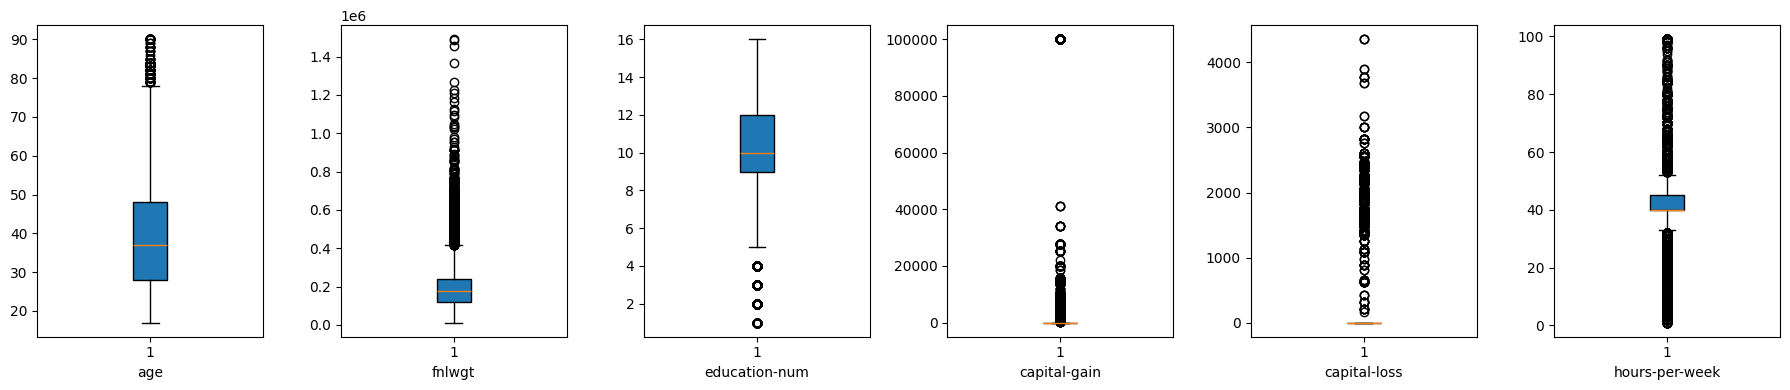

In [29]:
# Time to weed out the numerical and categorical features
numerical_features = [column for column in df.columns if df[column].dtype != object]
categorical_features = [column for column in df.columns if df[column].dtype == object]

columns_to_plot = numerical_features
counts_data = [df[col].values for col in columns_to_plot]

fig, ax = plt.subplots(1, 6, figsize=(18, 4))

for idx, column in enumerate(columns_to_plot):
    ax[idx].set_xlabel(column)
    ax[idx].boxplot(counts_data[idx],
                   patch_artist=True)  # fill with color


plt.tight_layout()
plt.show()

In [9]:
# Let's group some column data in order to minimize noise
def group_workclass(value):
    if value in ['Private']:
        return 'private-sector'
    elif value in ['Self-emp-not-inc', 'Self-emp-inc']:
        return 'self-employed'
    elif value in ['Local-gov', 'State-gov', 'Federal-gov']:
        return 'government'
    else:
        return 'other'

def groupped_marital_stat(value):
    # Married: 1
    # Single: 0
    if value in ['Married-civ-spouse', 'Married-spouse-absent', 'Married-AF-spouse']:
        return 1
    elif value in ['Never-married', 'Divorced', 'Separated', 'Widowed']:
        return 0

def groupped_occupation(occ):
    if occ in ['Prof-specialty', 'Exec-managerial', 'Adm-clerical', 'Tech-support', 'Sales']:
        return 'white_collar'
    elif occ in ['Craft-repair', 'Machine-op-inspct', 'Transport-moving',
                 'Handlers-cleaners', 'Farming-fishing', 'Protective-serv', 'Armed-Forces']:
        return 'blue_collar'
    elif occ in ['Other-service', 'Priv-house-serv']:
        return 'service'
    else:
        return 'other'

def group_relationship(value):
    # Lives with family: 1
    # Doesnt lives with family: 0
    if value in ['Husband', 'Wife', 'Own-child', 'Other-relative']:
        return 1
    elif value in ['Unmarried', 'Not-in-family']:
        return 0

def group_race(value):
    if value in ['Asian-Pac-Islander', 'Amer-Indian-Eskimo', 'Other']:
        return 'other'
    elif value in ['Black']:
        return 'black'
    elif value in ['White']:
        return 'white'

df['sex'] = df['sex'].apply(lambda val: 1 if val == 'Male' else 0)
df['y'] = df['y'].apply(lambda val: 1 if val == '>50K' else 0)

continent_map = {
    'United-States': 'North America',
    'Mexico': 'North America',
    'Canada': 'North America',
    'Puerto-Rico': 'North America',
    'El-Salvador': 'North America',
    'Cuba': 'North America',
    'Jamaica': 'North America',
    'Dominican-Republic': 'North America',
    'Guatemala': 'North America',
    'Haiti': 'North America',
    'Nicaragua': 'North America',
    'Honduras': 'North America',
    'Trinadad&Tobago': 'North America',
    'Outlying-US(Guam-USVI-etc)': 'Oceania',
    'Columbia': 'South America',
    'Peru': 'South America',
    'Ecuador': 'South America',
    'Germany': 'Europe',
    'England': 'Europe',
    'Italy': 'Europe',
    'Poland': 'Europe',
    'Portugal': 'Europe',
    'Greece': 'Europe',
    'France': 'Europe',
    'Ireland': 'Europe',
    'Scotland': 'Europe',
    'Yugoslavia': 'Europe',
    'Hungary': 'Europe',
    'Holand-Netherlands': 'Europe',
    'Philippines': 'Asia',
    'India': 'Asia',
    'China': 'Asia',
    'Japan': 'Asia',
    'Vietnam': 'Asia',
    'Taiwan': 'Asia',
    'Iran': 'Asia',
    'Cambodia': 'Asia',
    'Thailand': 'Asia',
    'Laos': 'Asia',
    'Hong': 'Asia',
    'South': 'Other',
    '?':'Other'
}



In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48813 entries, 0 to 48812
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             48813 non-null  int64 
 1   workclass       48813 non-null  object
 2   fnlwgt          48813 non-null  int64 
 3   education       48813 non-null  object
 4   education-num   48813 non-null  int64 
 5   marital-status  48813 non-null  object
 6   occupation      48813 non-null  object
 7   relationship    48813 non-null  object
 8   race            48813 non-null  object
 9   sex             48813 non-null  int64 
 10  capital-gain    48813 non-null  int64 
 11  capital-loss    48813 non-null  int64 
 12  hours-per-week  48813 non-null  int64 
 13  native-country  48813 non-null  object
 14  y               48813 non-null  int64 
dtypes: int64(8), object(7)
memory usage: 5.6+ MB


In [10]:
df["workclass"] = df["workclass"].apply(group_workclass)
df["marital-status"] = df["marital-status"].apply(groupped_marital_stat)
df["occupation"] = df["occupation"].apply(groupped_occupation)
df["relationship"] = df["relationship"].apply(group_relationship)
df['race'] = df['race'].apply(group_race)
df['continent'] = df['native-country'].map(continent_map)

In [11]:
# Remove the following columns:
# * fnlwgt : weight assignment according to how well the samples in the dataset represent the population. It has nothing to do with our research topic.
# * education: we already have the education-num column which is more informative
# * capital.gain and capital.loss: these columns are not very informative for our analysis
# * native.country: we already have the continent column which is more informative

df = df.drop(['fnlwgt','education','capital-gain', 'capital-loss','native-country'], axis=1)


In [12]:
display(df)

,age,workclass,education-num,marital-status,occupation,relationship,race,sex,hours-per-week,y,continent
0,39,government,13,0,white_collar,0,white,1,40,0,North America
1,50,self-employed,13,1,white_collar,1,white,1,13,0,North America
2,38,private-sector,9,0,blue_collar,0,white,1,40,0,North America
3,53,private-sector,7,1,blue_collar,1,black,1,40,0,North America
4,28,private-sector,13,1,white_collar,1,black,0,40,0,North America
...,...,...,...,...,...,...,...,...,...,...,...
48808,39,private-sector,13,0,white_collar,0,white,0,36,0,North America
48809,64,private-sector,9,0,white_collar,1,black,1,40,0,North America
48810,38,private-sector,13,1,white_collar,1,white,1,50,0,North America
48811,44,private-sector,13,0,white_collar,1,other,1,40,0,North America


# TODO
We still need to perform some more FE:
* imbalanced dataset ? 


In [26]:
from sklearn.utils.class_weight import compute_class_weight

classes = np.unique(y)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y)
class_weights = dict(zip(classes, weights))

class_weights

{np.int64(0): np.float64(0.5956582222873041),
 np.int64(1): np.float64(3.1134711060084195)}

In [27]:
from sklearn.model_selection import train_test_split

# Training time
X = df.drop('y', axis=1)
y = df['y']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=1970)

In [28]:
cat_features = [
    'workclass',
    'marital-status',
    'occupation',
    'relationship',
    'race',
    'continent',
    'sex',
    'continent'
]

In [29]:
from catboost import CatBoostClassifier
%matplotlib inline

clf = CatBoostClassifier(
    iterations=600,
    learning_rate=0.005,
    #loss_function='CrossEntropy',
    verbose=5,
    class_weights=class_weights
)


clf.fit(X_train, y_train,
        cat_features=cat_features,
        eval_set=(X_val, y_val),
        verbose=True
)

print('CatBoost model is fitted: ' + str(clf.is_fitted()))
print('CatBoost model parameters:')
print(clf.get_params())

0:	learn: 0.6905272	test: 0.6904652	best: 0.6904652 (0)	total: 19.1ms	remaining: 11.4s
1:	learn: 0.6878825	test: 0.6877918	best: 0.6877918 (1)	total: 41.5ms	remaining: 12.4s
2:	learn: 0.6853226	test: 0.6852238	best: 0.6852238 (2)	total: 59.4ms	remaining: 11.8s
3:	learn: 0.6826347	test: 0.6825447	best: 0.6825447 (3)	total: 81.6ms	remaining: 12.2s
4:	learn: 0.6801508	test: 0.6800624	best: 0.6800624 (4)	total: 100ms	remaining: 11.9s
5:	learn: 0.6776313	test: 0.6775142	best: 0.6775142 (5)	total: 124ms	remaining: 12.2s
6:	learn: 0.6751737	test: 0.6750256	best: 0.6750256 (6)	total: 142ms	remaining: 12s
7:	learn: 0.6726558	test: 0.6725076	best: 0.6725076 (7)	total: 162ms	remaining: 12s
8:	learn: 0.6702356	test: 0.6700665	best: 0.6700665 (8)	total: 180ms	remaining: 11.8s
9:	learn: 0.6679644	test: 0.6677895	best: 0.6677895 (9)	total: 199ms	remaining: 11.7s
10:	learn: 0.6654066	test: 0.6652343	best: 0.6652343 (10)	total: 216ms	remaining: 11.6s
11:	learn: 0.6630218	test: 0.6628481	best: 0.6628481

In [30]:
from sklearn.metrics import (accuracy_score,
                             classification_report,
                             confusion_matrix,
                             ConfusionMatrixDisplay,
                             RocCurveDisplay,
                             roc_curve,
                             auc)
from sklearn.model_selection import GridSearchCV

In [31]:
dt_pred =  clf.predict(X_val)

dt_val_acc = accuracy_score(y_val, dt_pred)
print("Catboost Accuracy Score", dt_val_acc)

Catboost Accuracy Score 0.7270306258322237


In [32]:
print("Decision Tree Classification Report")
print(classification_report(y_val, dt_pred))

Decision Tree Classification Report
              precision    recall  f1-score   support

           0       0.97      0.70      0.81      8217
           1       0.35      0.87      0.50      1546

    accuracy                           0.73      9763
   macro avg       0.66      0.78      0.66      9763
weighted avg       0.87      0.73      0.76      9763



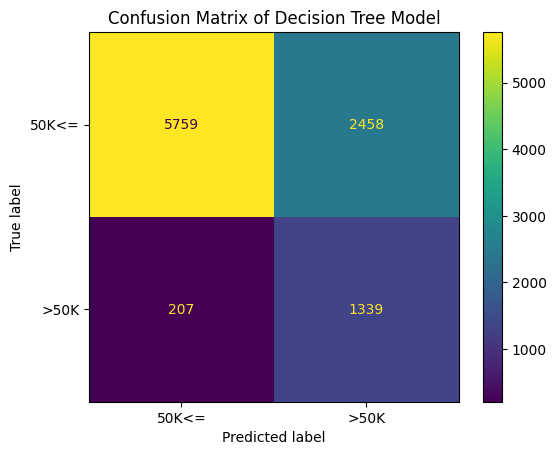

In [33]:
cm = confusion_matrix(y_val, dt_pred, labels=clf.classes_)
disp_cm = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['50K<=', '>50K'])
disp_cm.plot()
plt.title("Confusion Matrix of Decision Tree Model")
plt.show()

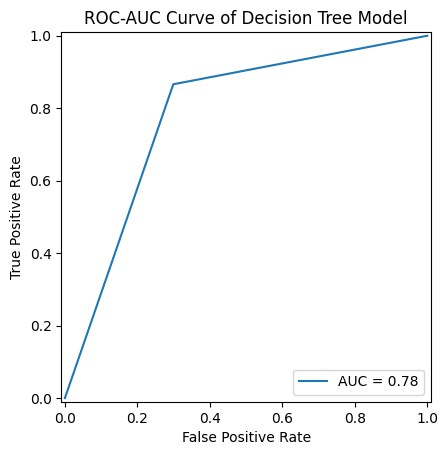

In [34]:
fpr, tpr, tresholds = roc_curve(y_val, dt_pred)
roc_auc = auc(fpr, tpr)
display = RocCurveDisplay(
    fpr=fpr,
    tpr=tpr,roc_auc=roc_auc
)
display.plot()
plt.title("ROC-AUC Curve of Decision Tree Model")
plt.show()

## Explain time

In [35]:
feature_importances = pd.Series(clf.feature_importances_, index=X_train.columns)
feature_importances = feature_importances.sort_values(ascending=False)

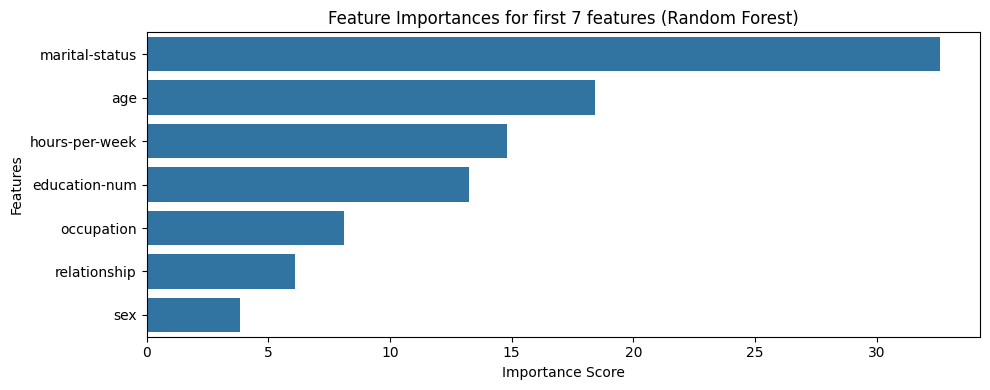

In [36]:
import seaborn as sns

plt.figure(figsize=(10, 4))
sns.barplot(x=feature_importances[:7], y=feature_importances.index[:7])

plt.title("Feature Importances for first 7 features (Random Forest)")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.tight_layout()
plt.show()

In [37]:
import shap
shap.initjs()

/Users/kristof/.local/share/virtualenvs/datascience/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [40]:
# Create a tree explainer
explainer = shap.Explainer(clf)
shap_values = explainer.shap_values(X_val)

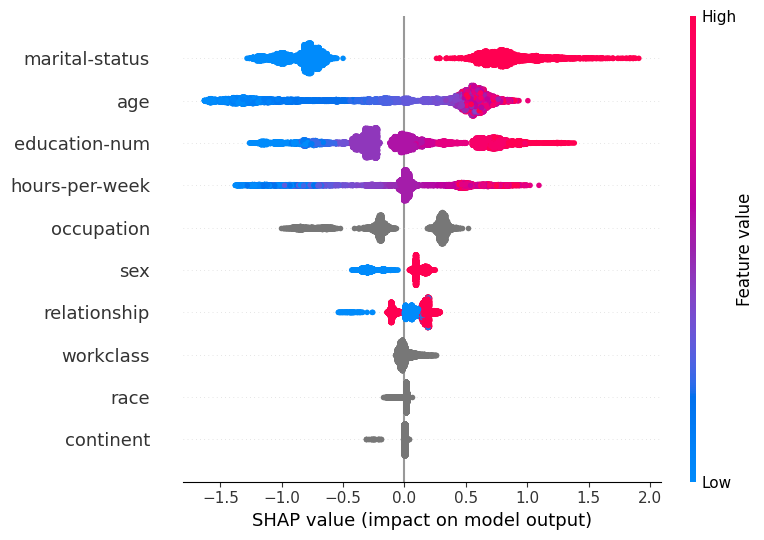

In [41]:
shap.summary_plot(shap_values, X_val)

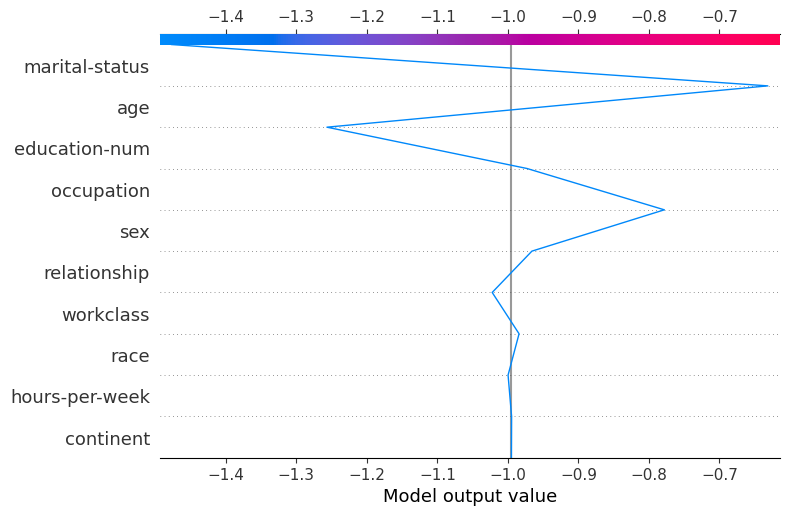

In [54]:
shap.decision_plot(explainer.expected_value, shap_values[1], X_val.columns)



In [48]:
shap_values.shape

(9763, 10)